In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importation des librairies**

In [2]:
import os
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.metrics
import seaborn
import matplotlib.pyplot as plt

## **Définition des variables**

Chemin d'accès aux fichiers de test

In [3]:
path_drive = '/content/drive/Shareddrives/Projet_Deep_Learning_ING3' # chemin d'accès au Drive partagé
path_test = os.path.join(path_drive, 'Cleaned_Test') # chemin d'accès aux dossiers de test
path_csv = os.path.join(path_drive, 'plants-specificities.csv') # chemin d'accès au tableau des caractères des plantes

Liste des classes

In [4]:
label_edges_names = ["lisse", "denté"]
label_phyllotaxis_names = ["alternée", "opposée"]
label_leaf_type_names = ["simple", "composée"]
label_ligneous_names = ["oui", "non"]

Tableau des caractères des plantes

In [5]:
plants_df = pd.read_csv(path_csv)

## **Lecture des images**

In [6]:
def get_features(path_directory):

  # On définit le tableau qui va contenir les matrices
  matrixes, labels_edge, labels_phyllotaxis, labels_leaf_type, labels_ligneous = [], [], [], [], []

  # On itère sur les sous-dossier de la racine : ils correspondent chacun à une classe
  for subdir in tqdm(os.listdir(path_directory)):

    # On définit subdir_path contenant le chemin absolue du sous-dossier courant
    subdir_path = os.path.join(path_directory, subdir)

    # On récupère le nom de l'espèce de la plante courante
    species_name = subdir.capitalize() # On récupère l'espèce de la plante : il s'agit du nom du dossier courant

    # On itère sur chacune des images contenues dans le sous-dossier courant
    for img in os.listdir(subdir_path):

      # On définit image_path contenant le chemin absolu de l'image courante
      img_path = os.path.join(subdir_path, img)

      # On lit l'image
      image = Image.open(img_path) # On récupère l'image via son chemin d'accès

      # On transforme l'image en une matrice numpy
      matrix = np.asarray(image)

      # On convertit la matrice en une matrice d'entiers codés sur un octet
      matrix.astype('uint8')
      
      # On ajoute la matrice à la liste des matrices
      matrixes.append(matrix)
      
      # On récupère la ligne correspondant à l'espèce de le tableau des caractères de plantes
      row = plants_df[plants_df["Nom"] == species_name].iloc[0]

      # On récupère les bons labels
      label_edge = label_edges_names.index(row["Bord"])
      label_phyllotaxis = label_phyllotaxis_names.index(row["Phyllotaxie"])
      label_leaf_type = label_leaf_type_names.index(row["Type Feuille"])
      label_ligneous = label_ligneous_names.index(row["Ligneux"])

      # On ajoute les données dans les listes associées aux caractères des plantes
      labels_edge.append(label_edge)
      labels_phyllotaxis.append(label_phyllotaxis)
      labels_leaf_type.append(label_leaf_type)
      labels_ligneous.append(label_ligneous)

  # On renvoie la liste des matrices et les liste des labels
  return matrixes, labels_edge, labels_phyllotaxis, labels_leaf_type, labels_ligneous

In [7]:
test_matrixes, test_labels_edge, test_labels_phyllotaxis, test_labels_leaf_type, test_labels_ligneous = get_features(path_test)

100%|██████████| 11/11 [00:29<00:00,  2.70s/it]


## **Chargement des modèles sauvegardés**

Configuration de Tensorflow

In [8]:
!apt-get install libcublas-11-4

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cuda-toolkit-11-4-config-common
The following NEW packages will be installed:
  cuda-toolkit-11-4-config-common libcublas-11-4
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 200 MB of archives.
After this operation, 463 MB of additional disk space will be used.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  cuda-toolkit-11-4-config-common 11.4.148-1 [16.2 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcublas-11-4 11.6.5.2-1 [200 MB]
Fetched 200 MB in 4s (52.7 MB/s)
Selecting previously unselected package cuda-toolkit-11-4-config-common.
(Reading database ... 124013 files and directories currently inst

In [9]:
tf.keras.backend.clear_session()

In [10]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

Lecture des données JSON depuis un fichier externe et création des modèles

In [11]:
def load_model(model_name):
  with open(os.path.join(path_drive, f'Model-RCNN-BinaryCrossentropy-V2/{model_name}.json'), 'r') as model_file:
    json_model = model_file.read()

  return tf.keras.models.model_from_json(json_model)

In [12]:
model_edge = load_model('Model-Edge')
model_phyllotaxis = load_model('Model-Phyllotaxis')
model_leaf_type = load_model('Model-LeafType')
model_ligneous = load_model('Model-Ligneous')

Création du modèle à partir des données au format JSON

## **Compilation des modèles**

In [13]:
def compile_model(model):
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
  )

In [14]:
compile_model(model_edge)
compile_model(model_phyllotaxis)
compile_model(model_leaf_type)
compile_model(model_ligneous)

## **Évaluation des modèles**

Mise en place des données de test

In [15]:
# On convertir les données de test en tableaux numpy pour transmettre les données aux réseaux de neurones
test_matrixes = np.array(test_matrixes, np.uint8) # Pour prendre moins de place en mémoire, les coefficients du tableau sont codés sur un octet

test_labels_edge = np.array(test_labels_edge)
test_labels_phyllotaxis = np.array(test_labels_phyllotaxis)
test_labels_leaf_type = np.array(test_labels_leaf_type)
test_labels_ligneous = np.array(test_labels_ligneous)

Prédictions sur les données de test

In [16]:
def predict_model(model):
  return np.argmax(model.predict(test_matrixes, batch_size=2), -1)

In [ ]:
predictions_edge = predict_model(model_edge)
predictions_phylloatxis = predict_model(model_phyllotaxis)
predictions_leaf_type = predict_model(model_leaf_type)
predictions_ligneous = predict_model(model_ligneous)

55/55 [==============================] - 279s 5s/step


Matrice de confusion

In [ ]:
def confusion_matrix_predictions(predictions, test_labels):
  return sklearn.metrics.confusion_matrix(predictions, test_labels, normalize='true')

In [ ]:
confusion_matrix_edge = confusion_matrix_predictions(predictions_edge, test_labels_edge)
confusion_matrix_phyllotaxis = confusion_matrix_predictions(predictions_phylloatxis, test_labels_phyllotaxis)
confusion_matrix_leaf_type = confusion_matrix_predictions(predictions_leaf_type, test_labels_leaf_type)
confusion_matrix_ligneous = confusion_matrix_predictions(predictions_ligneous, test_labels_ligneous)

Calculs du score F1

In [ ]:
def F1_score(model, model_name, confusion_matrix, test_labels, label_names):
  print(f'F1_score associé à ' + model_name)

  TP = confusion_matrix[0, 0]
  FN = confusion_matrix[1, 0]
  FP = confusion_matrix[0, 1]
  
  return TP / (TP + (FN + FP) / 2)

In [ ]:
print(F1_score(model_edge, 'Model-Edge', confusion_matrix_edge, test_labels_edge, label_edges_names), end='\n\n')
print(F1_score(model_phyllotaxis, 'Model-Phyllotaxis', confusion_matrix_phyllotaxis, test_labels_phyllotaxis, label_phyllotaxis_names), end='\n\n')
print(F1_score(model_leaf_type, 'Model-LeafType', confusion_matrix_leaf_type, test_labels_leaf_type, label_leaf_type_names), end='\n\n')
print(F1_score(model_ligneous, 'Model-Ligneous', confusion_matrix_ligneous, test_labels_ligneous, label_ligneous_names), end='\n\n')

F1_score associé à Model-Edge
0.8421052631578948

F1_score associé à Model-Phyllotaxis
0.0

F1_score associé à Model-LeafType
0.6412060301507537

F1_score associé à Model-Ligneous
0.0



Analyse des predictions

In [ ]:
def analyse_predictions(model, model_name, predictions, confusion_matrix, label_names):
  print(model_name, end='\n\n')

  seaborn.heatmap(confusion_matrix, cmap='rocket_r', xticklabels=label_names, yticklabels=label_names)

  plt.title("Matrice de confusion")
  plt.show()

  print()

  prediction_labels = map(lambda prediction: label_names[prediction], predictions)
  seaborn.countplot(x=list(prediction_labels))

  plt.title("Décomptes des classes prédites")
  plt.ylabel("Décompte")
  plt.xlabel("Class")
  plt.show()

  print()

Model-Edge



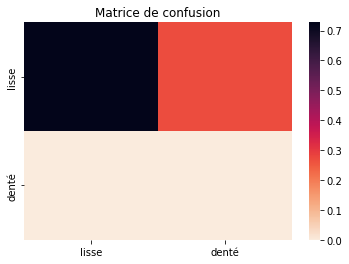

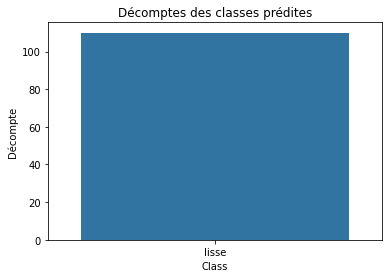


Model-Phyllotaxis



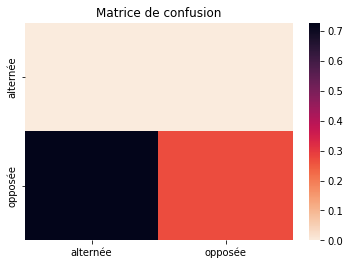

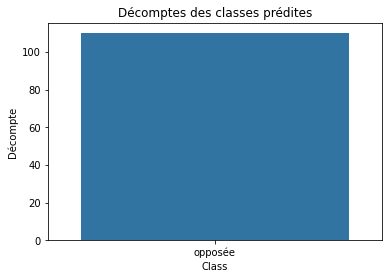


Model-LeafType




Model-Ligneous



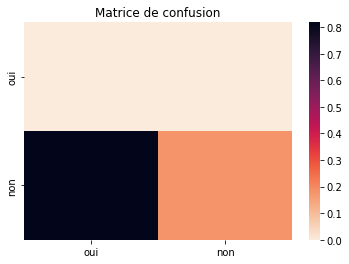

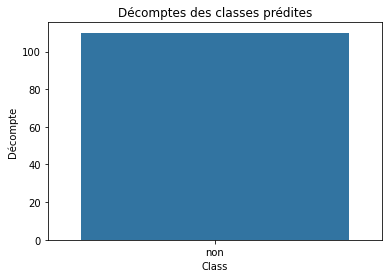

In [ ]:
analyse_predictions(model_edge, 'Model-Edge', predictions_edge, confusion_matrix_edge, label_edges_names)
analyse_predictions(model_phyllotaxis, 'Model-Phyllotaxis', predictions_phylloatxis, confusion_matrix_phyllotaxis, label_phyllotaxis_names)
analyse_predictions(model_leaf_type, 'Model-LeafType', predictions_leaf_type, confusion_matrix_leaf_type, label_leaf_type_names)
analyse_predictions(model_ligneous, 'Model-Ligneous', predictions_ligneous, confusion_matrix_ligneous, label_ligneous_names)